In [48]:
%pylab inline
from astropy import units as u
from astropy import constants
import sys
sys.path.append("../src/")

# Coefficients 
import read_coefficients as rbfe

# integrator
from leapfrog_bfe import integrate_bfe

# Coeff and fields viz
sys.path.append("../src/utils")
import fields_viz


#Gala 

import gala.potential as gp
import gala.dynamics as gd
import gala.integrate as gi

Populating the interactive namespace from numpy and matplotlib


/home/ngc/Work/research/BFE_integrator/bfe-orbits/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
#1 Read coefficients

path = "../data/coefficients/MW_halo/BFE_MW2_test_1M_snap_host_snap_000.txt"
S, Svar, T, Tvar, STcov = np.loadtxt(path, unpack=True)


In [3]:
!head "../data/coefficients/MW_halo/BFE_MW2_test_1M_snap_host_snap_000.txt"

#  nmax: 20 
#  lmax: 20 
#  r_s: 34.51 
#  particle_mass:  1.860e-03 
#  rcom: [-0.05942867  0.27544157  0.09918613] 
#  vcom: [1.44447289 3.49402871 1.05113301]
1.825461599745449917e+02 5.176498575029760962e-01 0.000000000000000000e+00 0.000000000000000000e+00 0.000000000000000000e+00
-1.647139018521598108e-01 3.339141828870554329e-01 0.000000000000000000e+00 0.000000000000000000e+00 0.000000000000000000e+00
6.189116310841151769e-01 6.751814974815678605e-01 2.217410639859059174e+00 6.719158568680313470e-01 -1.972367011578814774e-03
-1.495872208733557862e+00 1.057525991248066788e+00 0.000000000000000000e+00 0.000000000000000000e+00 0.000000000000000000e+00


In [4]:
pmass = 1.86e-3
nmax = 20
lmax = 20
rs = 34.51
M=1 
G = constants.G.to(u.kpc**3 / u.Msun / u.Gyr**2)


In [5]:
G

<Quantity 4.49850215e-06 kpc3 / (Gyr2 solMass)>

In [6]:
# Could read time-dependent-coefficients
Ssmooth, Tsmooth = rbfe.read_coefficients_smooth(path, pmass, M, nmax, lmax, sn=4)

/home/ngc/Work/research/BFE_integrator/notebooks/../src/coefficients_smoothing.py:142: RuntimeWarning: invalid value encountered in double_scalars
  bt = 1 / (1 + (varT/T**2))


In [7]:
# Viz fields 


twod_density = fields_viz.eval_2d_fields([Ssmooth[0], Tsmooth[0]], [M, rs, nmax, lmax, G], 
                                        [-100, 100, -100, 100, 50, 50, 0], "density")

In [9]:
twod_potential = fields_viz.eval_2d_fields([Ssmooth[0], Tsmooth[0]], [M, rs, nmax, lmax, G], 
                                        [-100, 100, -100, 100, 50, 50, 0], "potential")

In [10]:
twod_acceleration = fields_viz.eval_2d_fields([Ssmooth[0], Tsmooth[0]], [M, rs, nmax, lmax, G], 
                                        [-100, 100, -100, 100, 50, 50, 0], "acceleration")

(<Figure size 864x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Density'}>,
        <AxesSubplot:title={'center':'Potential'}>,
        <AxesSubplot:title={'center':'Acceleration'}>], dtype=object))

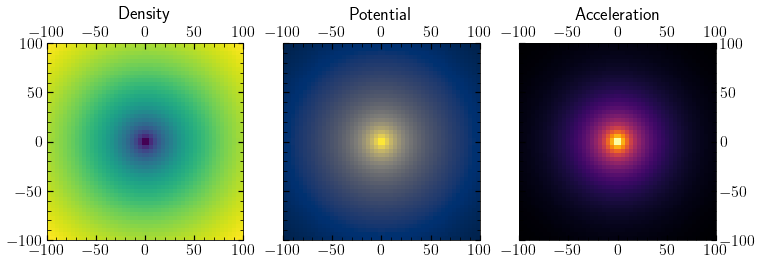

In [11]:
fields_viz.viz_all_fields([np.log10(twod_density.value), 
                           twod_potential, twod_acceleration], grid_size=[-100, 100, -100, 100])

In [94]:
#2 Set orbit parameters

#G = constants.G.to(u.kpc  *u.km**2 / u.s**2 / u.Msun) #* 1E10 
G = constants.G.to(u.kpc**3 / u.Gyr**2 / u.Msun) * 1E10 

x=100 # kpc
y=0
z=0
vx = 0*u.km/u.s
vy = -230*u.km/u.s # km/s  ? 
vz = 0*u.km/u.s
time = 2 # Gyr
S_nlm = Ssmooth[0]
T_nlm = Tsmooth[0]
G_c = G # 
M = 1 # 
r_s = rs # kpc 
interp_dt = 0.002 # Gyr
disk=0 



In [95]:
G_c

<Quantity 44985.0215147 kpc3 / (Gyr2 solMass)>

In [96]:
#3 Run orbit

orbit_test = integrate_bfe(x, y, z, vx, vy, vz, time, S_nlm, T_nlm, nmax, lmax,
                          G_c, M, r_s, interp_dt, disk, LMC=0)


In [97]:
#4 Read results

In [98]:
torb, xorb, yorb, zorb, vxorb, vyorb, vxorb = orbit_test

In [108]:
r = (xorb**2 + yorb**2 + zorb**2)**0.5

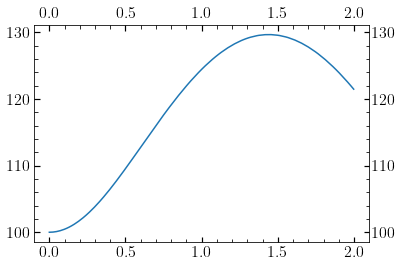

In [109]:
plot(torb, r)

In [110]:
# Comaparisson with Gala
x

100

In [127]:
1.86E-3 * 1E6 * 1E10 / 1E12

18.6

In [155]:
mw = gp.HernquistPotential(m=1.86E12, c=40.85, units=[u.kpc, u.Gyr, u.Msun, u.radian])
w = gd.PhaseSpacePosition(pos=[x, y, z], vel=[vx.value, vy.value, vz.value])
g_orbit = mw.integrate_orbit(w, dt=0.002*u.Gyr, n_steps=1000, Integrator=gi.LeapfrogIntegrator)

In [156]:
g_r = g_orbit.xyz


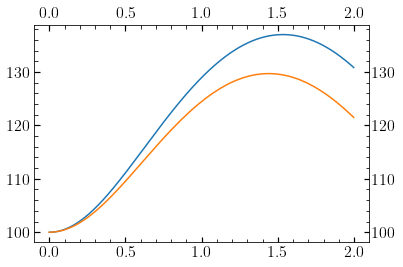

In [157]:
plot(torb, np.sqrt(np.sum(g_r**2, axis=0))[:-1])
plot(torb, r)